# Potato Disease Classification

In [37]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2

## Set all the Constants

In [2]:
CHANNELS = 3
n_classes = 3
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

## Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"E:\DS ML DL\DL Specialization\DL\DL Projects\Potato Disease Classification\PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
print(len(dataset))
68 * 32

68


2176

## Visualize some of the images from our dataset

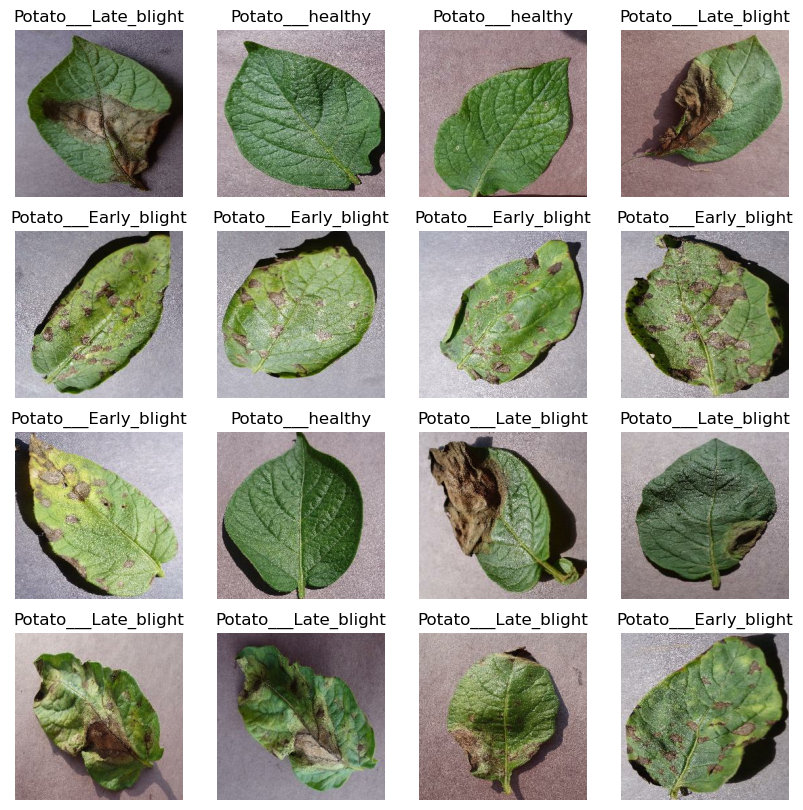

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Trian Test Split

- 80% ===> Training
- 20% ===> Validation
- 20% ===> Validation

In [7]:
def get_dataset_partition(ds, train_split = 0.8,val_split = 0.1,test_split = 0.1, shuffle = True , shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

In [8]:
train_ds , test_ds , val_ds = get_dataset_partition(dataset)

In [9]:
print("Train_size : ",len(train_ds))
print("Validation_size : ",len(val_ds))
print("Test_size : ",len(test_ds))

Train_size :  54
Validation_size :  6
Test_size :  8


In [ ]:
Cache, Shuffle, and Prefetch the Dataset

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Building the Model
Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



In [11]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [12]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])

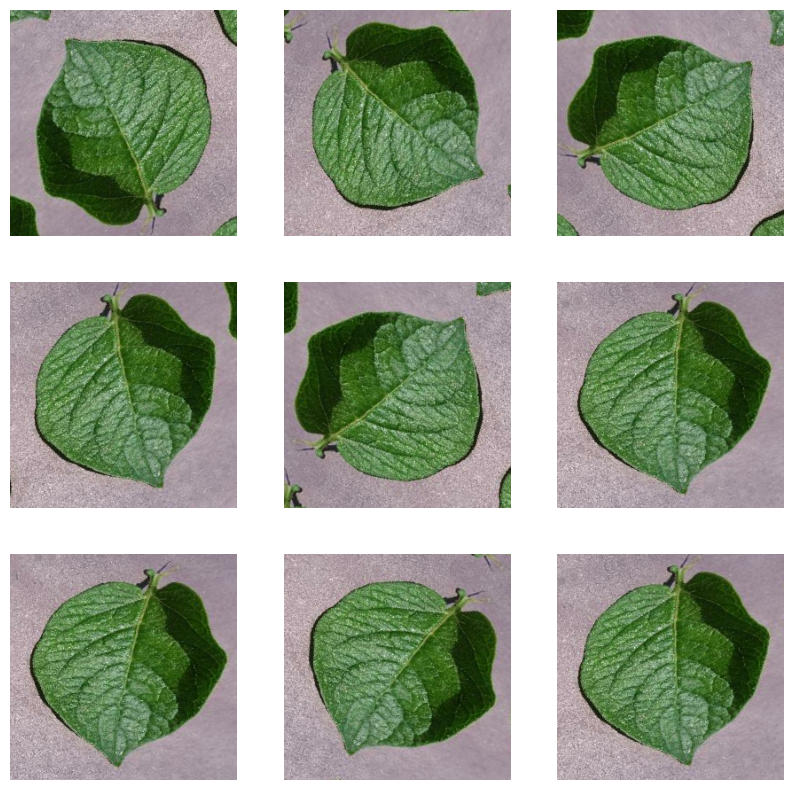

In [13]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')

## Trainig my own CNN model and also using ResNet50 and MobileNetV2 as transfer learning

In [14]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = models.Sequential([
    resize_and_scale,
    
    data_augmentation,
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    

    layers.Flatten(),
    layers.Dense(64,activation = "relu"),
    layers.Dense(n_classes, activation = "softmax"),
    
])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [17]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4722 - loss: 0.9158 - val_accuracy: 0.4583 - val_loss: 0.9399
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.6505 - loss: 0.7663 - val_accuracy: 0.7083 - val_loss: 0.7150
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7980 - loss: 0.4885 - val_accuracy: 0.8906 - val_loss: 0.3082
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8501 - loss: 0.3626 - val_accuracy: 0.8802 - val_loss: 0.2988
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8611 - loss: 0.3451 - val_accuracy: 0.8750 - val_loss: 0.3187
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8686 - loss: 0.3282 - val_accuracy: 0.8906 - val_loss: 0.3124
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8814 - loss: 0.3122 - val_accuracy: 0.8438 - val_loss: 0.3699
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8976 - loss: 0.2718 - val_accuracy: 0.9323 - v

In [23]:
model.evaluate(test_ds.skip(0))

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.9648 - loss: 0.0944


[0.09438172727823257, 0.96484375]

In [19]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False  
model_res_net = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [20]:
model_res_net.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [30]:
model_res_net.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,375,691 (92.99 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,320 (2.00 MB)

In [21]:
history = model_res_net.fit(
    train_ds,
    epochs = 7,
    batch_size = BATCH_SIZE,
    validation_data = val_ds
)

Epoch 1/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.8530 - loss: 0.4181 - val_accuracy: 0.9583 - val_loss: 0.1278
Epoch 2/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.9624 - loss: 0.1237 - val_accuracy: 0.9688 - val_loss: 0.0694
Epoch 3/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9693 - loss: 0.0929 - val_accuracy: 0.9844 - val_loss: 0.0537
Epoch 4/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9786 - loss: 0.0701 - val_accuracy: 0.9948 - val_loss: 0.0303
Epoch 5/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.9821 - loss: 0.0566 - val_accuracy: 0.9896 - val_loss: 0.0292
Epoch 6/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.9878 - loss: 0.0444 - val_accuracy: 0.9948 - val_loss: 0.0200
Epoch 7/7
54/54 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.9878 - loss: 0.0420 - val_accuracy: 0.9948 - val_loss: 0.0171


In [24]:
model_res_net.evaluate(test_ds.skip(0))

8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9922 - loss: 0.0178


[0.01777038350701332, 0.9921875]

In [26]:
base_model = MobileNetV2(
    weights='imagenet',        
    include_top=False,        
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False  

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 71s 8us/step


In [31]:
model_mobilenet.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [32]:
model_mobilenet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
history = model_mobilenet.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9479 - loss: 0.1411 - val_accuracy: 0.9427 - val_loss: 0.1330
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9601 - loss: 0.1201 - val_accuracy: 0.9531 - val_loss: 0.1056
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9635 - loss: 0.1152 - val_accuracy: 0.9635 - val_loss: 0.1075
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9578 - loss: 0.1154 - val_accuracy: 0.9688 - val_loss: 0.0928
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9612 - loss: 0.0994 - val_accuracy: 0.9479 - val_loss: 0.1215
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9693 - loss: 0.1018 - val_accuracy: 0.9740 - val_loss: 0.0775
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9693 - loss: 0.0821 - val_accuracy: 0.9688 - val_loss: 0.0822
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9682 - loss: 0.0892 - val_accuracy: 0.9740 - val_loss:

In [37]:
model_mobilenet.evaluate(test_ds.skip(0))

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 0.0096   


[0.009596211835741997, 1.0]

In [39]:
model_mobilenet.evaluate(train_ds.skip(0))

54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9977 - loss: 0.0118


[0.011798643507063389, 0.9976851940155029]

In [40]:
model_mobilenet.evaluate(val_ds.skip(0))

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9844 - loss: 0.0362


[0.036204684525728226, 0.984375]

In [43]:
print(history.params)
print(history.history.keys())

{'verbose': 'auto', 'epochs': 50, 'steps': 54}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Plotting Model History of MobileNetV2 as it gives the best result on the test data

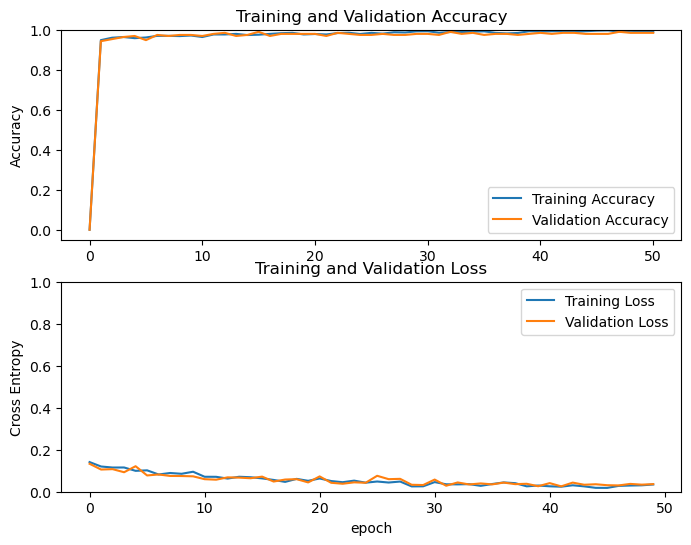

In [61]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

First Image to Predict
Actual Label is :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Label is :  Potato___Late_blight


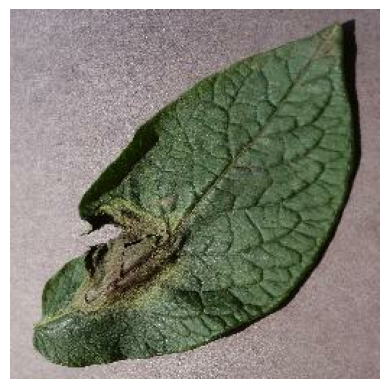

In [20]:
for images_batch, labels_batch in test_ds.take(1):
    first_image =  images_batch[0].numpy().astype("uint")
    first_label = labels_batch[0]
    print("First Image to Predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label is : ", class_names[first_label])
    batch_prediction = model_mobilenet.predict(images_batch)
    print("Predicted Label is : ",class_names[np.argmax(batch_prediction[0])])

## Prediction Function

In [29]:
def predict(model_res_net, img):
    img_array = tf.expand_dims(img, 0)

    predictions = model_mobilenet.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


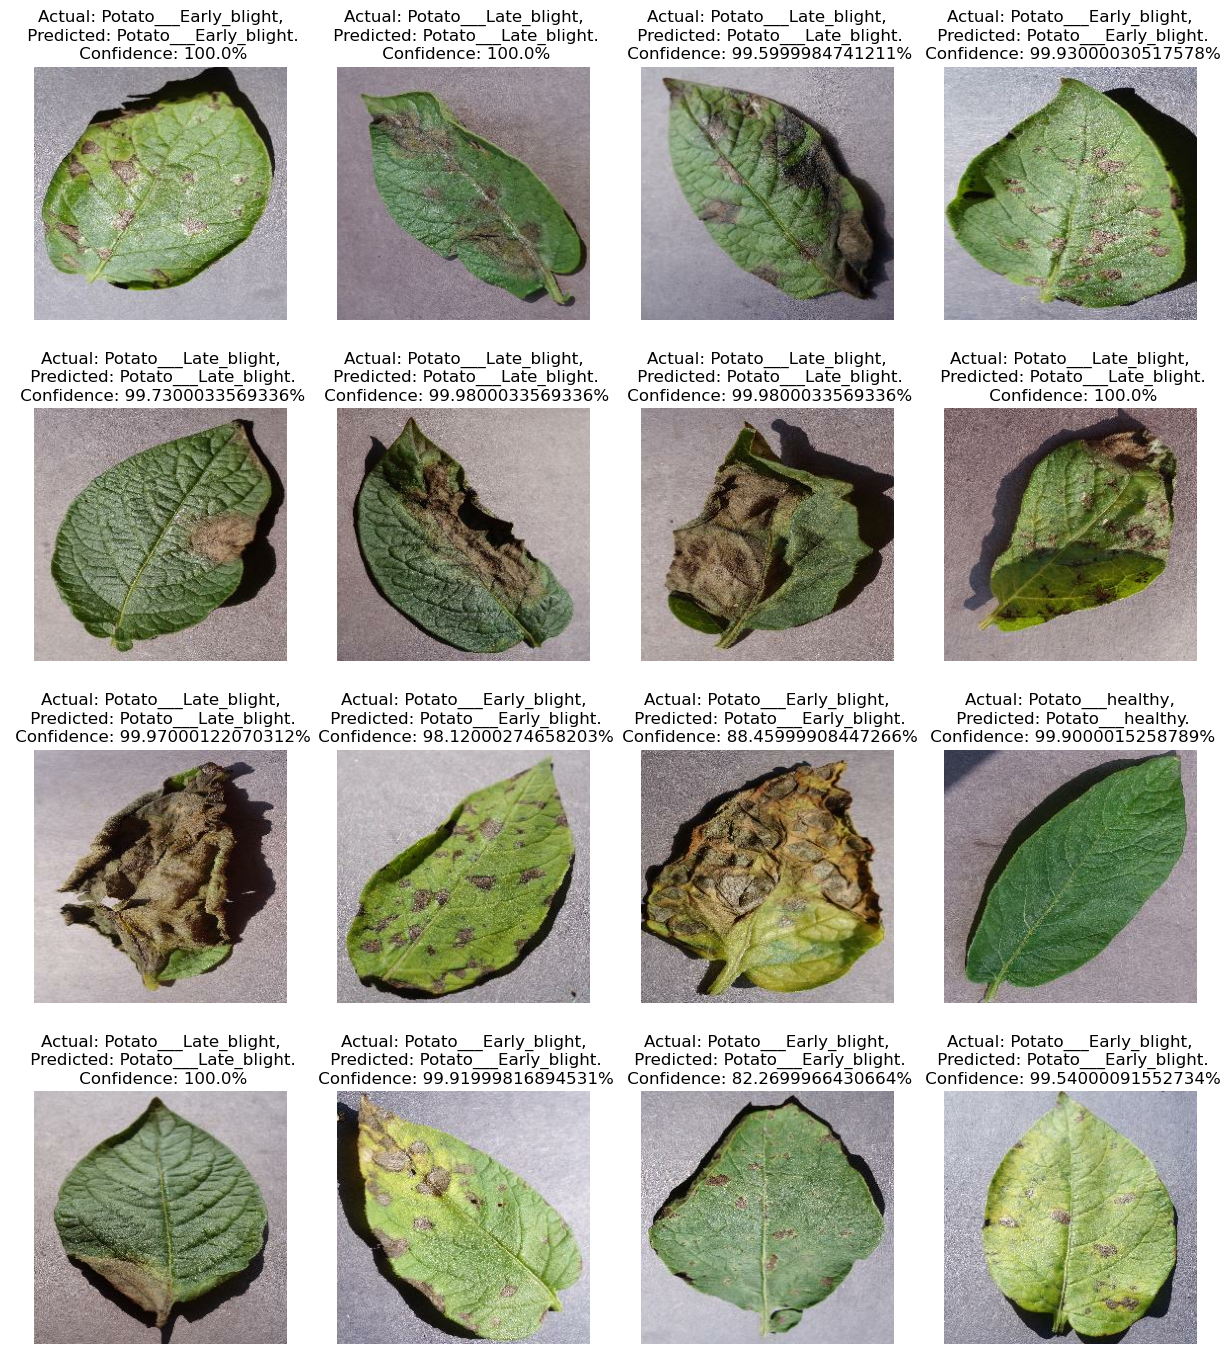

In [35]:
plt.figure(figsize=(15, 17))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_mobilenet, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving All Three Models

In [54]:
model.save("1model.keras")

In [55]:
model_mobilenet.save("1model_mobilenet.keras")

In [56]:
model_res_net.save("1model_res_net.keras")

In [19]:
model_mobilenet = tf.keras.models.load_model(
    r"E:\DS ML DL\DL Specialization\DL\DL Projects\Potato Disease Classification\Training\Models\1model_mobilenet.keras")